In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time 

df = pd.read_pickle('data/pkl/PreciosBlue.xlsx.pkl')
df

,Fecha,Compra,Venta
0,2023-01-31,379.00,383.00
1,2023-01-30,382.00,386.00
2,2023-01-27,381.00,385.00
3,2023-01-26,379.00,383.00
4,2023-01-25,377.00,381.00
...,...,...,...
3216,2010-01-07,3.86,3.87
3217,2010-01-06,3.87,3.88
3218,2010-01-05,3.86,3.86
3219,2010-01-04,3.86,3.86


In [2]:
# renaming for fbprophet
df.rename(columns={'Fecha':'ds'}, inplace=True)
df.rename(columns={'Venta':'y'}, inplace=True)
df.reset_index(inplace=True)
df.head()

,index,ds,Compra,y
0,0,2023-01-31,379.0,383.0
1,1,2023-01-30,382.0,386.0
2,2,2023-01-27,381.0,385.0
3,3,2023-01-26,379.0,383.0
4,4,2023-01-25,377.0,381.0


In [3]:
df.rename(columns={'Fecha':'ds'}, inplace=True)

In [4]:
df = df[df['ds'] >= '2018-01-01']

df

,index,ds,Compra,y
0,0,2023-01-31,379.00,383.00
1,1,2023-01-30,382.00,386.00
2,2,2023-01-27,381.00,385.00
3,3,2023-01-26,379.00,383.00
4,4,2023-01-25,377.00,381.00
...,...,...,...,...
1270,1270,2018-01-05,19.05,19.45
1271,1271,2018-01-04,19.01,19.41
1272,1272,2018-01-03,18.89,19.29
1273,1273,2018-01-02,18.85,19.25


In [5]:
df.drop(['Compra'], axis=1)

,index,ds,y
0,0,2023-01-31,383.00
1,1,2023-01-30,386.00
2,2,2023-01-27,385.00
3,3,2023-01-26,383.00
4,4,2023-01-25,381.00
...,...,...,...
1270,1270,2018-01-05,19.45
1271,1271,2018-01-04,19.41
1272,1272,2018-01-03,19.29
1273,1273,2018-01-02,19.25


In [6]:
df = df.sort_values(by='ds')

In [7]:
df

,index,ds,Compra,y
1273,1273,2018-01-02,18.85,19.25
1272,1272,2018-01-03,18.89,19.29
1271,1271,2018-01-04,19.01,19.41
1270,1270,2018-01-05,19.05,19.45
1269,1269,2018-01-08,19.18,19.58
...,...,...,...,...
3,3,2023-01-26,379.00,383.00
2,2,2023-01-27,381.00,385.00
1,1,2023-01-30,382.00,386.00
0,0,2023-01-31,379.00,383.00


In [8]:
df['y'].round(2).describe()

count    1275.000000
mean      131.634439
std        90.833488
min        19.250000
25%        43.875000
50%       132.000000
75%       195.000000
max       386.000000
Name: y, dtype: float64

In [9]:
from prophet import Prophet

prophet_model = Prophet()
prophet_model.fit(df)

c:\Users\rodri\anaconda3.1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
19:17:31 - cmdstanpy - INFO - Chain [1] start processing
19:17:32 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
future_dataset= prophet_model.make_future_dataframe(periods=1, freq='y') # Data para el proximo año
future_dataset.tail()

,ds
1237,2023-01-27
1238,2023-01-30
1239,2023-01-31
1240,2023-02-01
1241,2023-12-31


In [11]:
pred = prophet_model.predict(future_dataset)
pred[['ds','yhat', 'yhat_lower', 'yhat_upper']].head() # only useful columns

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-02,26.465718,11.978429,39.966602
1,2018-01-03,27.442573,14.129773,41.631834
2,2018-01-04,27.577753,14.449620,41.876879
3,2018-01-05,27.867316,14.640714,41.411461
4,2018-01-08,28.020976,14.564763,41.825600


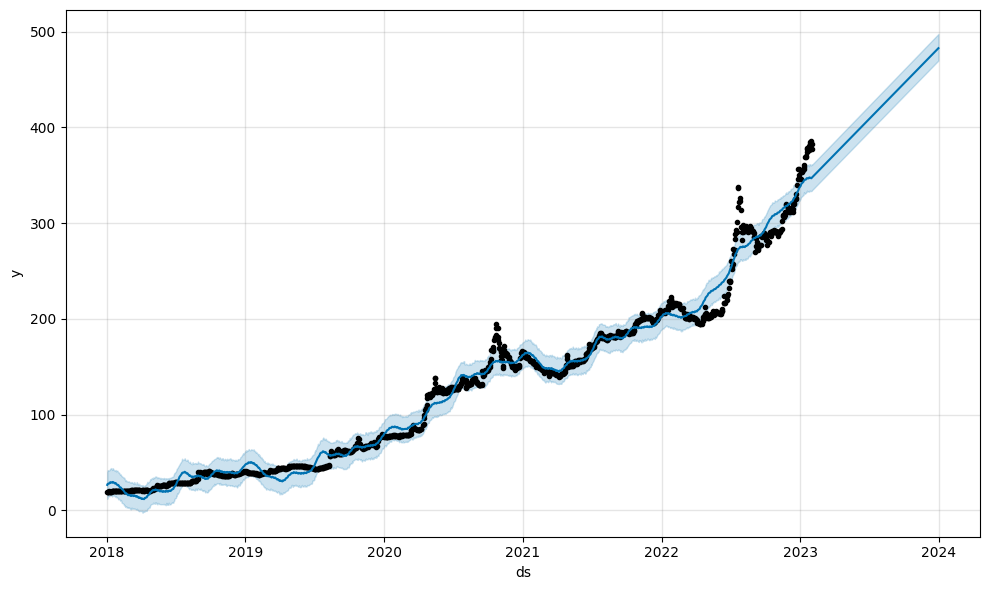

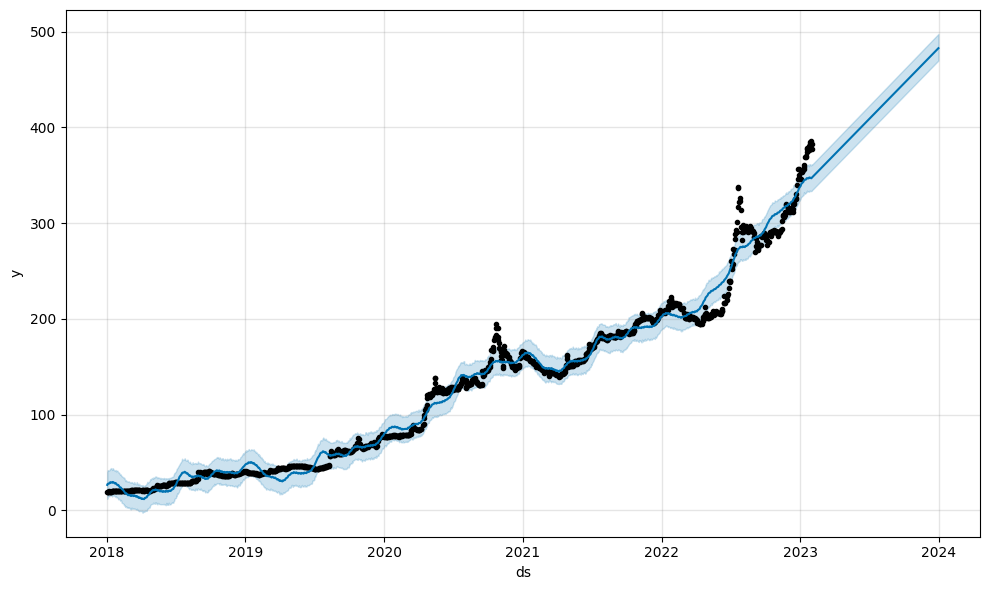

In [12]:
prophet_model.plot(pred)

In [13]:
def fb_prophet_function(data, future_years, seasonality_name, seasonality_val,seasonality_fourier, **params):
    """
    Trains a fb prophet model on given hyperparameters and custom
    seasonality, predicts on future dataset, plot the results and
    return the model.
    """
    start= time.time()
    prophet_model = Prophet(**params)
    
    prophet_model.add_seasonality(name=seasonality_name, period=seasonality_val, fourier_order=seasonality_fourier)
        
    prophet_model.fit(data)
    
    future_dataset = prophet_model.make_future_dataframe(periods=future_years, freq='y')
    
    pred = prophet_model.predict(future_dataset)
    
    prophet_model.plot(pred, figsize=(15,7));
    plt.ylim(-500, 3000)
    plt.title(f"fourier order{seasonality_fourier}, seasonality time {seasonality_name}")
    plt.show()
    
    end = time.time()
    print(f"Total Execution Time {end-start} seconds")
    return prophet_model

In [14]:
def plot_valid(validation_set, size, model):
    pred = model.predict(validation_set)
    temp = df[-size:].copy().reset_index()
    temp['pred']=pred['yhat']
    temp.set_index('ds')[['y', 'pred']].plot()
    plt.tight_layout();

19:17:46 - cmdstanpy - INFO - Chain [1] start processing
19:18:29 - cmdstanpy - INFO - Chain [1] done processing


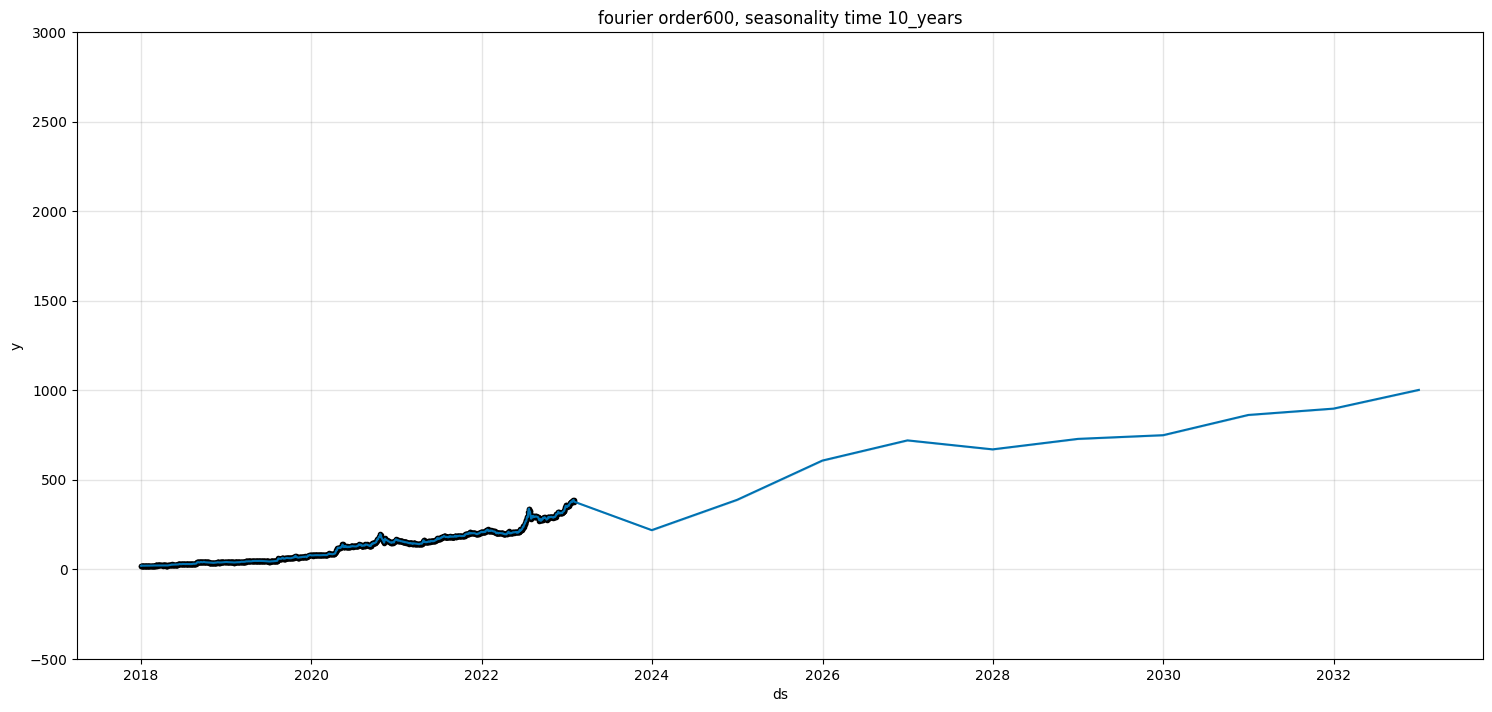

Total Execution Time 55.336973428726196 seconds


In [15]:
import time

training_set = df
validation_set = df 

ten_years = fb_prophet_function(data=training_set, future_years=10, seasonality_name='10_years', seasonality_val=365*10, seasonality_fourier=600,seasonality_mode='additive')

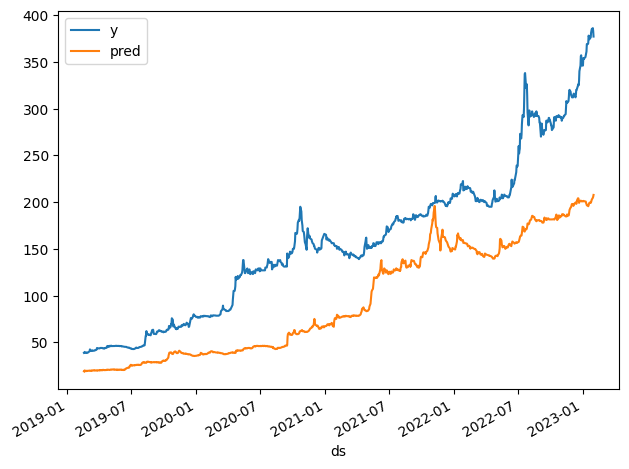

In [16]:
plot_valid(validation_set, 1000, ten_years)

In [17]:
pred = pred[['ds', 'yhat']]

pred

,ds,yhat
0,2018-01-02,26.465718
1,2018-01-03,27.442573
2,2018-01-04,27.577753
3,2018-01-05,27.867316
4,2018-01-08,28.020976
...,...,...
1237,2023-01-27,347.503453
1238,2023-01-30,346.811469
1239,2023-01-31,347.097258
1240,2023-02-01,347.613885


In [18]:
validation_set = validation_set[['ds', 'y']]

validation_set

,ds,y
1273,2018-01-02,19.25
1272,2018-01-03,19.29
1271,2018-01-04,19.41
1270,2018-01-05,19.45
1269,2018-01-08,19.58
...,...,...
3,2023-01-26,383.00
2,2023-01-27,385.00
1,2023-01-30,386.00
0,2023-01-31,383.00


In [19]:
pred = pred[pred['ds'].isin(validation_set['ds'])]

pred

,ds,yhat
0,2018-01-02,26.465718
1,2018-01-03,27.442573
2,2018-01-04,27.577753
3,2018-01-05,27.867316
4,2018-01-08,28.020976
...,...,...
1236,2023-01-26,347.526433
1237,2023-01-27,347.503453
1238,2023-01-30,346.811469
1239,2023-01-31,347.097258


In [20]:
merged1 = pd.merge(pred, validation_set, on='ds', how='inner')

validation_ds_y = merged1[['ds', 'y']]
pred_ds_yhat = merged1[['ds', 'yhat']]


In [21]:
validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())

C:\Users\rodri\AppData\Local\Temp\ipykernel_20052\2616818827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
C:\Users\rodri\AppData\Local\Temp\ipykernel_20052\2616818827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())


In [22]:
validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)

C:\Users\rodri\AppData\Local\Temp\ipykernel_20052\476390056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
C:\Users\rodri\AppData\Local\Temp\ipykernel_20052\476390056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)


In [23]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mae1 = mean_absolute_error(validation_ds_y, pred_ds_yhat)
mse1 = mean_squared_error(validation_ds_y, pred_ds_yhat)
rmse1 = math.sqrt(mean_squared_error(validation_ds_y, pred_ds_yhat))

print("Mean Absolute Error: ", mae1)
print("Mean Squared Error: ", mse1)
print("Root Mean Squared Error: ", rmse1)


Mean Absolute Error:  3.857502072976289
Mean Squared Error:  56.091018850294255
Root Mean Squared Error:  7.489393757193853


In [24]:
df = df[df['ds'] >= '2021-01-01']

df

,index,ds,Compra,y
538,538,2021-01-04,159.0,165.0
537,537,2021-01-05,154.0,160.0
536,536,2021-01-06,154.0,160.0
535,535,2021-01-07,156.0,162.0
534,534,2021-01-08,155.0,161.0
...,...,...,...,...
3,3,2023-01-26,379.0,383.0
2,2,2023-01-27,381.0,385.0
1,1,2023-01-30,382.0,386.0
0,0,2023-01-31,379.0,383.0


19:18:39 - cmdstanpy - INFO - Chain [1] start processing
19:18:54 - cmdstanpy - INFO - Chain [1] done processing


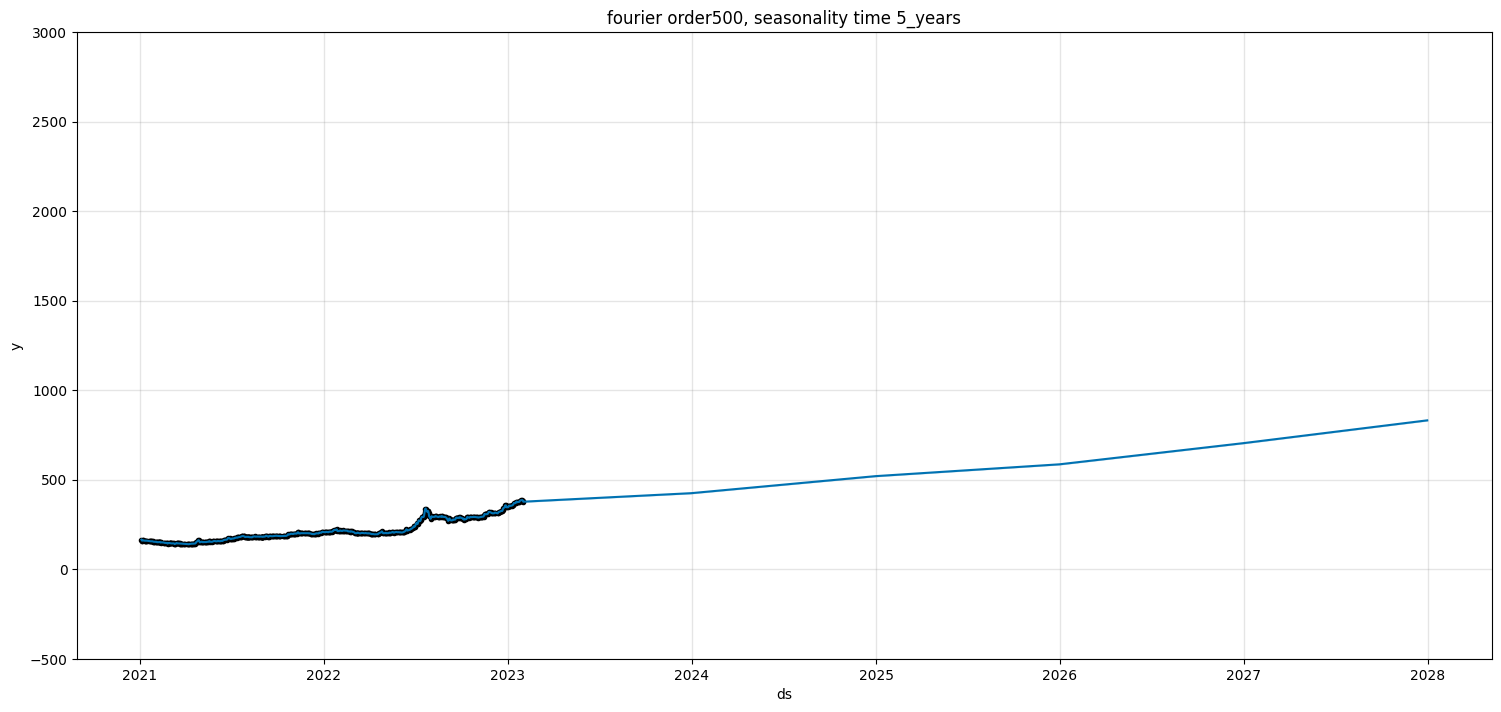

Total Execution Time 17.878544807434082 seconds


In [25]:
training_set = df
validation_set = df

five_years_model = fb_prophet_function(data=training_set, future_years=5, seasonality_name='5_years', seasonality_val=365*5, seasonality_fourier=500,seasonality_mode='additive')

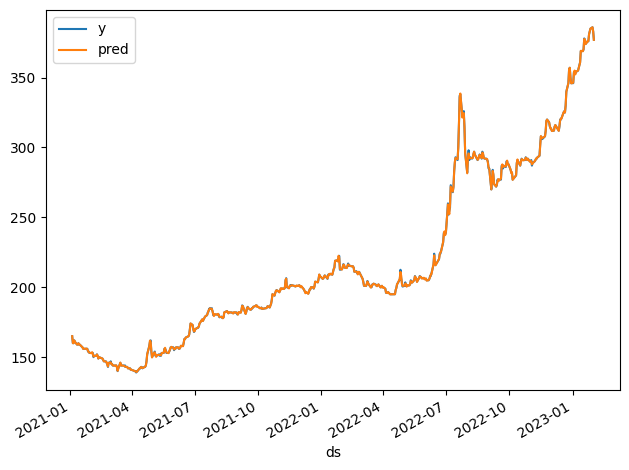

In [26]:
plot_valid(validation_set, 1000, five_years_model)

In [27]:
from prophet.diagnostics import cross_validation, performance_metrics

model = Prophet()
model.fit(df)

df_cv = cross_validation(model, initial='360 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv, rolling_window=0.1) 
 
df_p.head()

19:18:56 - cmdstanpy - INFO - Chain [1] start processing
19:18:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/1 [00:00<?, ?it/s]

19:18:57 - cmdstanpy - INFO - Chain [1] start processing
19:18:57 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,34 days,188.679814,13.736077,10.694656,0.051966,0.042839,0.049800,0.12
1,35 days,213.372958,14.607291,11.661144,0.056760,0.043699,0.054309,0.08
2,36 days,234.964939,15.328566,12.537451,0.061060,0.051105,0.058364,0.04
3,37 days,259.950283,16.122974,13.400467,0.065348,0.052153,0.062367,0.04
4,38 days,288.253373,16.978026,14.315185,0.069921,0.052686,0.066614,0.04


In [28]:
from sklearn.metrics import mean_squared_error
pred = pred[['ds', 'yhat']]

pred
validation_set = validation_set[['ds', 'y']]

validation_set
pred = pred[pred['ds'].isin(validation_set['ds'])]

pred
merged2 = pd.merge(pred, validation_set, on='ds', how='inner')

validation_ds_y = merged2[['ds', 'y']]
pred_ds_yhat = merged2[['ds', 'yhat']]

validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())
validation_ds_y['ds'] = validation_ds_y['ds'].astype(float)
pred_ds_yhat['ds'] = pred_ds_yhat['ds'].astype(float)
import math

mae2 = mean_absolute_error(validation_ds_y, pred_ds_yhat)
mse2 = mean_squared_error(validation_ds_y, pred_ds_yhat)
rmse2 = math.sqrt(mean_squared_error(validation_ds_y, pred_ds_yhat))

print("Mean Absolute Error: ", mae2)
print("Mean Squared Error: ", mse2)
print("Root Mean Squared Error: ", rmse2)


Mean Absolute Error:  4.726598487331099
Mean Squared Error:  89.06833982425593
Root Mean Squared Error:  9.437602440464206


C:\Users\rodri\AppData\Local\Temp\ipykernel_20052\4273972159.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_ds_y['ds'] = validation_ds_y['ds'].apply(lambda x: x.timestamp())
C:\Users\rodri\AppData\Local\Temp\ipykernel_20052\4273972159.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_ds_yhat['ds'] = pred_ds_yhat['ds'].apply(lambda x: x.timestamp())
C:\Users\rodri\AppData\Local\Temp\ipykernel_20052\4273972159.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [29]:
from prophet import Prophet

five_years_model = Prophet(seasonality_mode='additive', seasonality_prior_scale=1, 
                         yearly_seasonality=True, weekly_seasonality=False, 
                         daily_seasonality=False)


In [30]:
five_years_model.add_seasonality(name='1_years', period=365*1, fourier_order=90)

In [31]:
import datetime

today = datetime.datetime.now()
next_month = today + datetime.timedelta(days=90)
start_date = today.strftime("%Y-%m-%d")
end_date = next_month.strftime("%Y-%m-%d")
date_range = pd.date_range(start_date, end_date)
next_month = pd.DataFrame({"ds": date_range})


In [32]:
five_years_model.fit(training_set)

prediction = five_years_model.predict(next_month)

19:19:00 - cmdstanpy - INFO - Chain [1] start processing
19:19:05 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
values = prediction['yhat']

values_new = pd.DataFrame(values)

values_new = values_new.rename(columns={'yhat':'Values'})

values_new

,Values
0,380.835679
1,381.188679
2,382.550073
3,382.493264
4,380.543065
...,...
86,384.119166
87,379.853896
88,376.856444
89,377.097786


In [34]:
# import the datetime library
import datetime

# define the start date (today + 1) and the number of days in the range
start_date = datetime.datetime.today() + datetime.timedelta(days=1)
num_days = len(values_new.index)

# create the date range
date_range = [start_date.date() + datetime.timedelta(days=i) for i in range(num_days)]

# set the index of the dataframe to the date range
values_new.index = date_range

values_new


,Values
2023-02-02,380.835679
2023-02-03,381.188679
2023-02-04,382.550073
2023-02-05,382.493264
2023-02-06,380.543065
...,...
2023-04-29,384.119166
2023-04-30,379.853896
2023-05-01,376.856444
2023-05-02,377.097786


In [35]:
values_new.to_excel("data/xlsx/values_newBlue.xlsx")

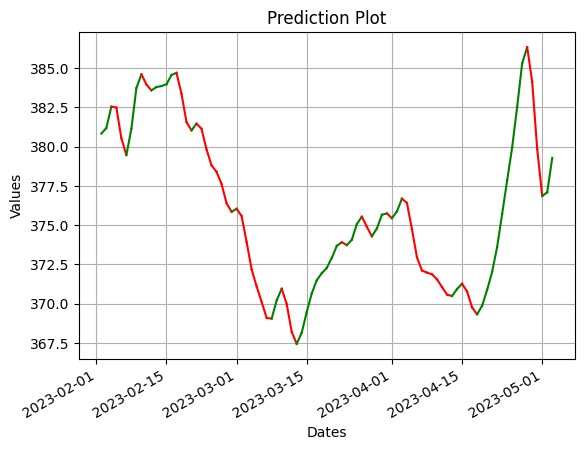

In [36]:
x = values_new.index
y = values_new['Values']
for i in range(1, len(values_new)):
    if y[i] > y[i-1]:
        color = 'g'
    else:
        color = 'r'
    plt.plot(x[i-1:i+1], y[i-1:i+1], color=color)
plt.xlabel("Dates")
plt.ylabel("Values")
plt.title("Prediction Plot")
plt.grid()
plt.gcf().autofmt_xdate()
plt.show()


In [37]:
import plotly.graph_objs as go
import plotly.offline as pyo

data = []
for i in range(1, len(values_new)):
    if y[i] > y[i-1]:
        color = 'green'
    else:
        color = 'red'
    trace = go.Scatter(x=x[i-1:i+1], y=y[i-1:i+1], mode='lines', line=dict(color=color, width=1), showlegend=False)
    data.append(trace)

layout = go.Layout(title='Prediccion Dolar Blue', xaxis=dict(title='Fecha'), yaxis=dict(title='Valores'))
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

In [38]:
with open('data/html/Predicciones/Pred_DolarBlue.html', 'w') as f:
    f.write(fig.to_html(include_plotlyjs='cdn'))